In [5]:
import os

import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)  # need 1.9.0 or greater

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

5.15.0


In [6]:
data = pd.read_csv('wiki_machine_learning.csv',sep=' ')
data.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [7]:
data.shape

(384, 7)

In [8]:
data.dtypes

date     object
count     int64
lang     object
page     object
rank      int64
month     int64
title    object
dtype: object

In [9]:
data.date = pd.to_datetime(data.date)

In [10]:
#Выделение временного ряда
series = data.set_index("date")[["count"]]
series.head()

,count
date,
2015-01-01,1414
2015-01-02,1920
2015-01-03,1338
2015-01-04,1404
2015-01-05,2264


In [6]:
#Временной ряд - график
plotly_df(data.set_index("date")[["count"]])

In [11]:
data.columns

Index(['date', 'count', 'lang', 'page', 'rank', 'month', 'title'], dtype='object')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

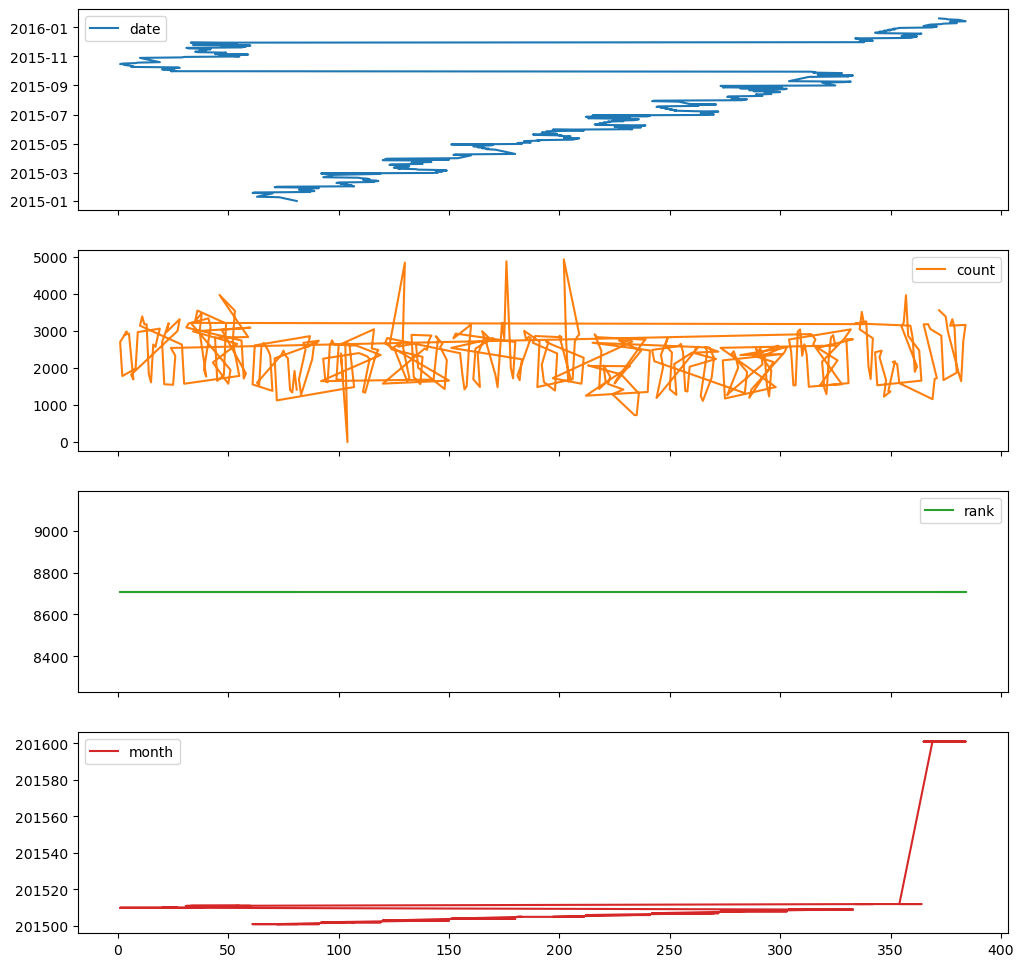

In [9]:
data.plot(subplots=True,figsize=(12,12))

<Axes: xlabel='date'>

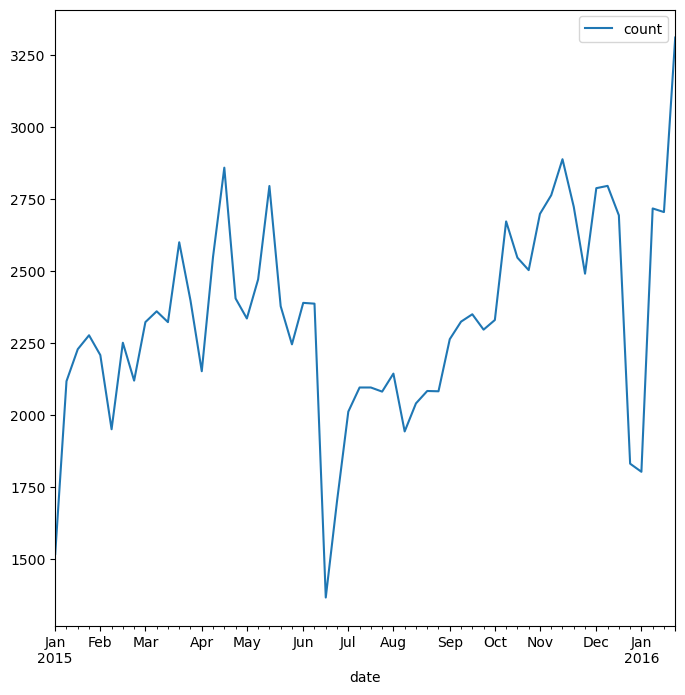

In [12]:
#Сводка по месяцу
data2 = series.resample('W').mean()
data2.plot(figsize=(8,8))

In [13]:
#Статистика
result = series.describe()
print(result.head())

             count
count   384.000000
mean   2331.445312
std     669.885936
min       0.000000
25%    1723.500000


In [14]:
#Коэффициент вариации
print ('V = %f' % (result.std()/result.mean()))

V = 0.838425


In [15]:
#Тест Харки-Бера для проверки гипотезы о нормальном распределении (p-value<0.05, значит ряд имеет нормальное распределение)
import statsmodels.api as sm
import numpy as np
import tables
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(series)
a = np.vstack([jb_test])
result = a,row
print(result)

(array([[9.06041047],
       [0.01077846],
       [0.13475556],
       [3.70259477]]), ['JB', 'p-value', 'skew', 'kurtosis'])


In [16]:
#Обобщенный тест Дикки-Фуллера для проверки стационарности ряда
test = sm.tsa.adfuller(series)
print('adf:',test[0])

adf: -3.2997371711587067


In [17]:
print('p-value:',test[1])

p-value: 0.01489022703734832


In [18]:
print('Critical values:',test[4])

Critical values: {'1%': -3.4482453822848496, '5%': -2.8694261442901396, '10%': -2.5709711770439507}


In [19]:
#результаты проверки стационарности ряда
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

единичных корней нет, ряд стационарен


In [20]:
#Порядок интегрирования для ряда
series1diff = series.diff(periods=1).dropna()
print(series1diff)

             count
date              
2015-01-02   506.0
2015-01-03  -582.0
2015-01-04    66.0
2015-01-05   860.0
2015-01-06    63.0
...            ...
2016-01-16 -1099.0
2016-01-17   192.0
2016-01-18  1147.0
2016-01-19   406.0
2016-01-20   170.0

[383 rows x 1 columns]


In [21]:
#Проверка гипотезы о средних
m = series.index[len(series.index)/2+1]
r1 = sm.stats.DescrStatsW(series[m:])
r2 = sm.stats.DescrStatsW(series[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  [0.02513771]


C:\Users\sholo\AppData\Local\Temp\ipykernel_6460\3206951160.py:2: FutureWarning:

Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.



<Axes: xlabel='date'>

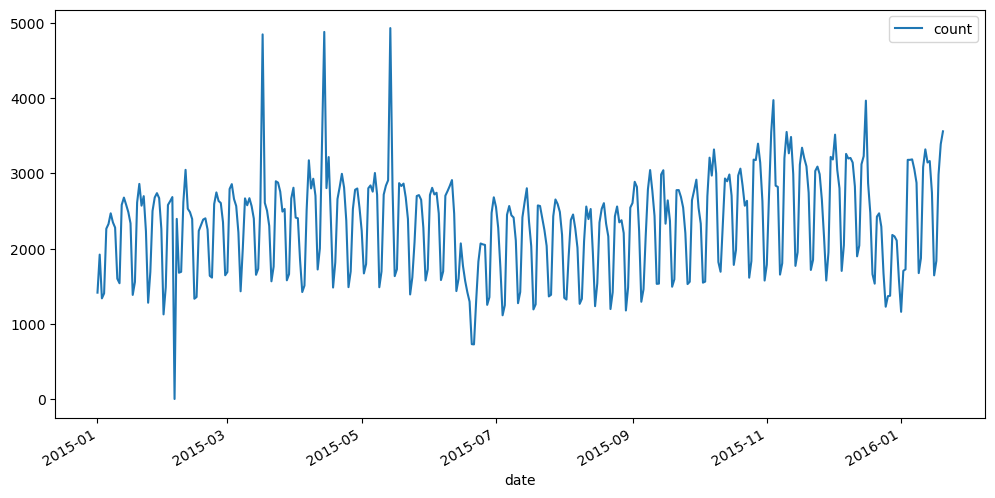

In [22]:
series.plot(figsize=(12,6))

C:\Users\sholo\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



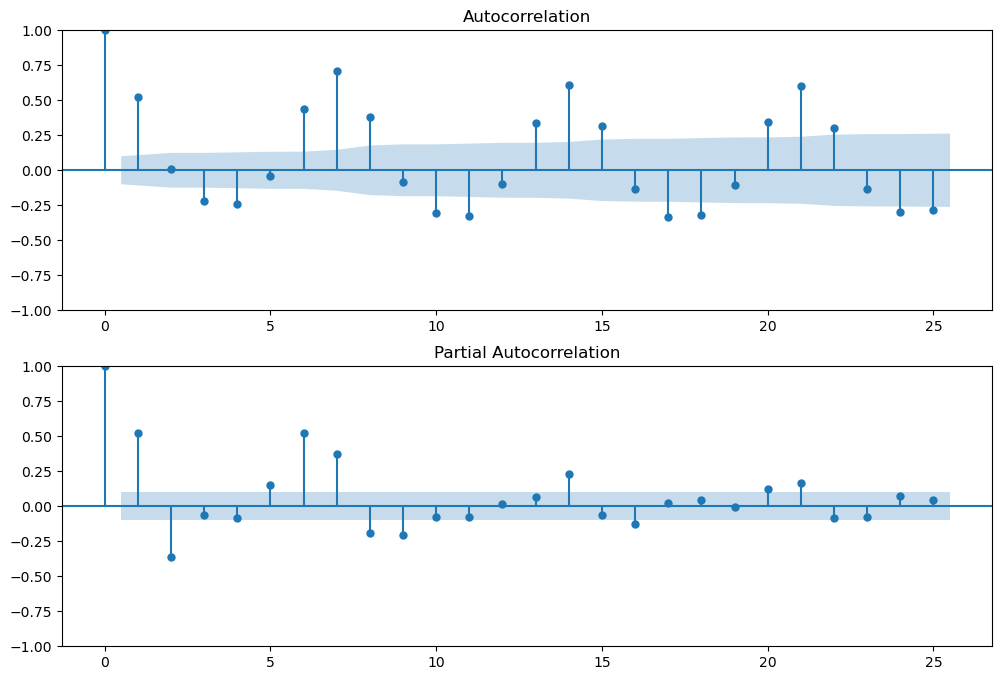

In [23]:
#Построение коррелограмм, количество лагов- число значимых коэффициентов
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=25, ax=ax2)

In [25]:
#Начальные приближения
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [26]:
#SARIMAX модель
best_model = sm.tsa.statespace.SARIMAX(series, order=(4, d, 3), 
                                        seasonal_order=(4, 1, D, 24)).fit(disp=-1)
print(best_model.summary())  

C:\Users\sholo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\sholo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\sholo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                                count   No. Observations:                  384
Model:             SARIMAX(4, 1, 3)x(4, 1, [1], 24)   Log Likelihood               -2718.665
Date:                              Fri, 21 Jul 2023   AIC                           5463.330
Time:                                      02:55:04   BIC                           5513.813
Sample:                                           0   HQIC                          5483.405
                                              - 384                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1038      0.149      7.404      0.000       0.812       1.396
ar.L2         -1.18

C:\Users\sholo\AppData\Local\Temp\ipykernel_6460\3190102359.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sholo\AppData\Local\Temp\ipykernel_6460\3190102359.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\sholo\AppData\Local\Temp\ipykernel_6460\3190102359.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

02:56:22 - cmdstanpy - INFO - Chain [1] start 

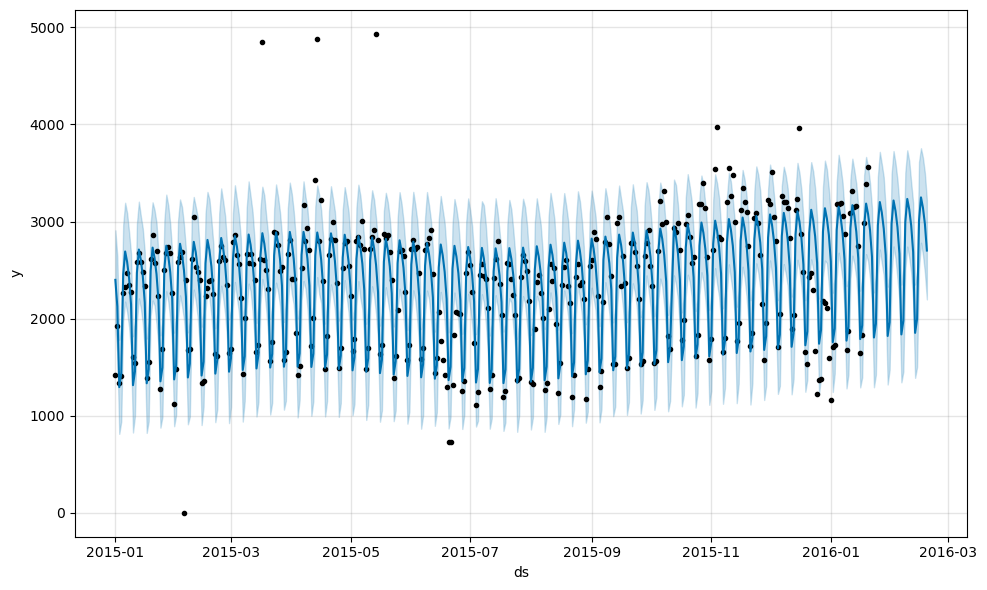

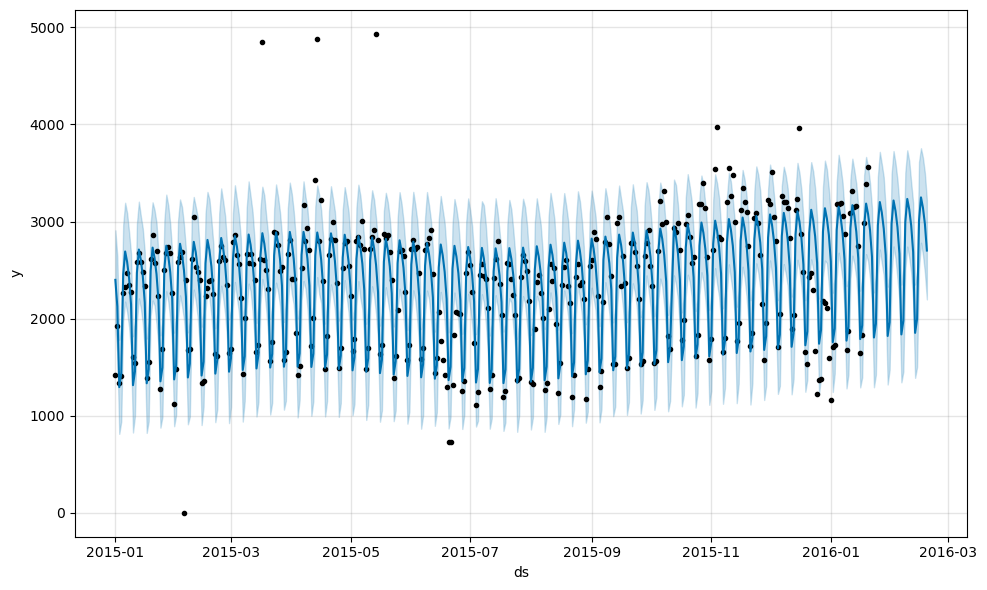

In [28]:
from prophet import Prophet
predictions = 30
new_df=data[['date','count']]
new_df['date']=pd.to_datetime(new_df['date'])
new_df.rename(columns = {'date':'ds'}, inplace = True)
new_df.rename(columns = {'count':'y'}, inplace = True)
m = Prophet()
m.fit(new_df)
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)
m.plot(forecast)

In [29]:
#MAE
from sklearn.metrics import mean_absolute_error
y_true = new_df["y"].values[:384]
y_pred = forecast['yhat'].values[:384]
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true=y_true, y_pred=y_pred))

Mean Absolute Error (MAE): 230.80868532669652


In [35]:
#MASE
n = y_true.shape[0]
d = np.abs(np.diff(y_true)).sum()/(n-1)
errors = np.abs(y_true-y_pred)
print(errors.mean()/d)

0.5005505307331319


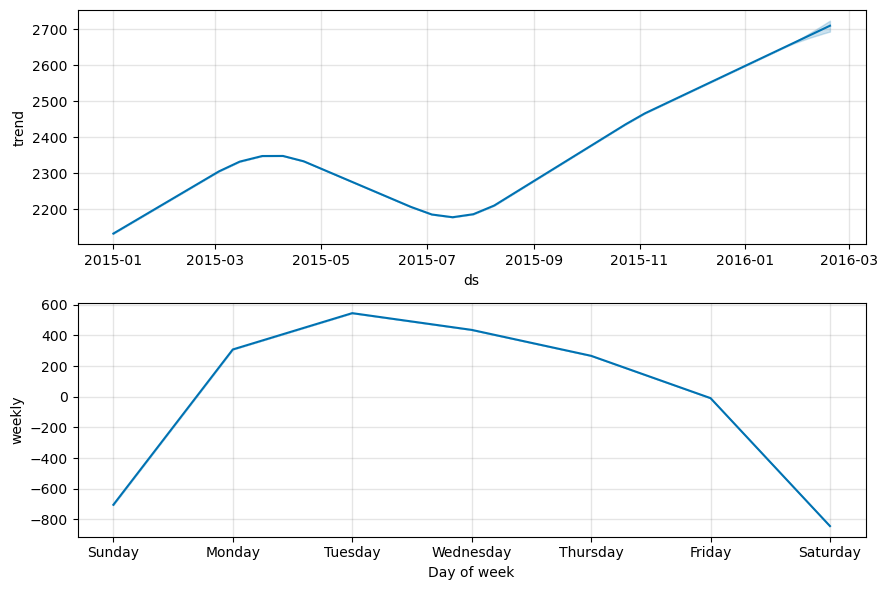

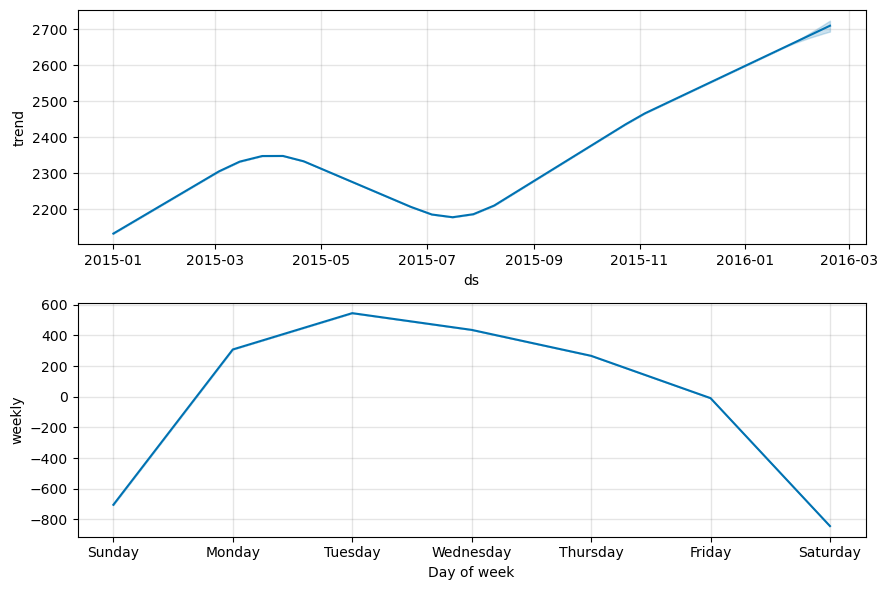

In [73]:
m.plot_components(forecast)